In [1]:
import os
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.stats import norm
from itertools import cycle
from random import shuffle
from sklearn.model_selection import train_test_split


import torch
from torch import nn
import torch.optim as opt
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from livelossplot import PlotLosses
from mpl_toolkits.axes_grid1 import ImageGrid
from collections import OrderedDict

from sprites import Sprites
from cycle_consistent_vae import Encoder, Decoder

np.random.bit_generator = np.random._bit_generator

In [2]:
cuda = 1
device = torch.device("cuda:{}".format(cuda) if torch.cuda.is_available() else "cpu")

MODEL_PATH = "./models/cycle_vae_06052020-030456_99.pth"
checkpoint = torch.load(MODEL_PATH)

Z_DIM = 16 #Style Dimension (Unspecified)
S_DIM = 16 # Class Dimension (Specified)

encoder = Encoder(style_dim=Z_DIM, class_dim=S_DIM)
encoder.load_state_dict(checkpoint['encoder'])

decoder = Decoder(style_dim=Z_DIM, class_dim=S_DIM)
decoder.load_state_dict(checkpoint['decoder'])


encoder.to(device)
# encoder.eval()

Encoder(
  (conv_model): Sequential(
    (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_1): ReLU(inplace)
    (conv_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_2): ReLU(inplace)
    (conv_3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_3): ReLU(inplace)
    (conv_4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (bn_4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_4): ReLU(inplace)
  )
  (style_mu): Linear(in_features=512, out_features=16, bias=True)
  (style_logvar): Linear(in_features=512, out_features=16, bias=True)
  (class_output): Line

In [3]:
decoder.to(device)
# decoder.eval()

Decoder(
  (style_input): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (class_input): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (deconv_model): Sequential(
    (deconv_1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2))
    (de_bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leakyrelu_1): LeakyReLU(negative_slope=0.2, inplace)
    (deconv_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
    (de_bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leakyrelu_2): LeakyReLU(negative_slope=0.2, inplace)
    (deconv_3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
    (de_bn_3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (leakyrelu_3): LeakyReLU(negative_slope=0.2, i

In [4]:
def reparameterize(training, mu, logvar):
    if training:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    else:
        return mu

In [24]:
def imshow_grid(images, shape=[2, 8], name='default', save=False):
    """
    Plot images in a grid of a given shape.
    Initial code from: https://github.com/pumpikano/tf-dann/blob/master/utils.py
    """
    fig = plt.figure(1,figsize=(12, 12))
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)

    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i])  # The AxesGrid object work as a list of axes.

    if save:
        plt.savefig('./test_images/' + str(name) + '.png')
        plt.clf()
    else:
        plt.show()

# Dataset processing

In [6]:
BATCH_SIZE = 16
test_data = Sprites()
train_loader = cycle(DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2, drop_last=True))

# Style tranfer grid

### Making a 9x9 grid

In [7]:
grid = [None for i in range(9*9)]

In [8]:
def get_constructed_sprite(class_img, style_img):
    with torch.no_grad():
        class_img = class_img.reshape(1,60,60,3)
        class_img = torch.transpose(class_img, 2,3)
        class_img = torch.transpose(class_img, 1,2)
        
        style_img = style_img.reshape(1,60,60,3)
        style_img = torch.transpose(style_img, 2,3)
        style_img = torch.transpose(style_img, 1,2)
        
        _, _, s_1 = encoder(class_img)
        z_mu_1, z_logvar_1, _ = encoder(style_img)
        z_1 = reparameterize(training=False, mu=z_mu_1, logvar=z_logvar_1)
        
        recons = decoder(z_1, s_1)
        
        return np.transpose(recons.detach().cpu().numpy(), (0, 2, 3, 1)).reshape(60,60,3)
    

In [19]:
elem1 = next(train_loader)

In [20]:
samples = elem1['img1'][:8,:,:,:].to(device)

In [21]:
count=0
for i in range(9):
    for j in range(9):
        if i==0 and j==0:
            count+=1
            continue
        elif i==0:
            grid[count]=samples[j-1].detach().cpu().numpy()
            count+=1
        elif j==0:
            grid[count]=samples[i-1].detach().cpu().numpy()
            count+=1
        else:
            grid[count]=get_constructed_sprite(samples[j-1], samples[i-1])
            count+=1

In [22]:
grid[0] = np.zeros(shape=(60,60,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

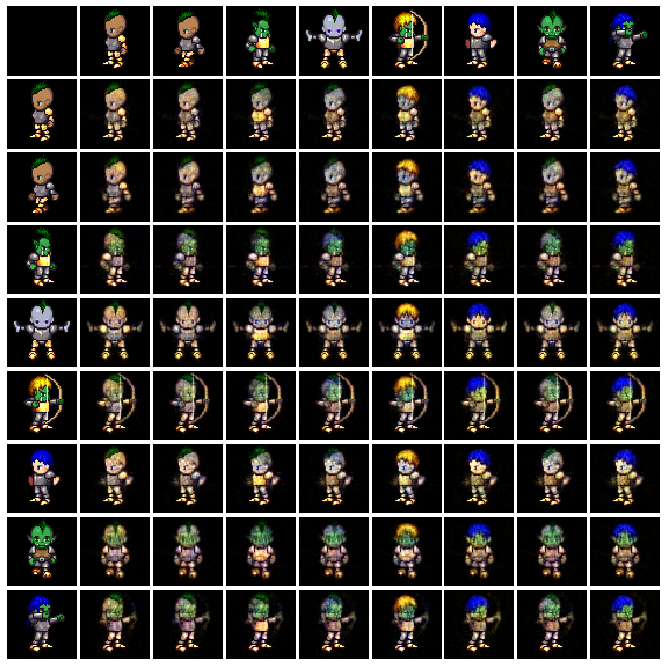

In [25]:
imshow_grid(grid, shape=[9, 9], save=False)